Final Project Program - Rushi Chavda - 20D100007

In [1]:
!pip -q install rdkit-pypi

In [2]:
import ast

import pandas as pd
import numpy as np

import tensorflow as tf
import keras
from keras import layers

import matplotlib.pyplot as plt
from rdkit import Chem, RDLogger
from rdkit.Chem.Draw import MolsToGridImage

RDLogger.DisableLog("rdApp.*")

In [3]:
# data loading and basic preprocessing
df = pd.read_csv(r"dataset\250k_rndm_zinc_drugs_clean_3.csv")
df['smiles'] = df['smiles'].apply(lambda s: s.replace('\n', ''))
df.head()
df = df[:1000].copy()

In [4]:
# To convert smile into molecule represnetation, which one can see. basiclly i have used a famous library rdkit to do this.

def molecule_from_smiles(smiles):
    molecule = Chem.MolFromSmiles(smiles, sanitize=False)
    flag = Chem.SanitizeMol(molecule, catchErrors=True)
    if flag != Chem.SanitizeFlags.SANITIZE_NONE:
        Chem.SanitizeMol(molecule, sanitizeOps=Chem.SanitizeFlags.SANITIZE_ALL ^ flag)

    Chem.AssignStereochemistry(molecule, cleanIt=True, force=True)
    return molecule
    

SMILES:	CCc1ccc(CNC(=O)c2ccc(-c3nccnc3N3CCCCC3)cc2)cc1
logP:	4.6263
qed:	0.6265585492769999
Molecule:


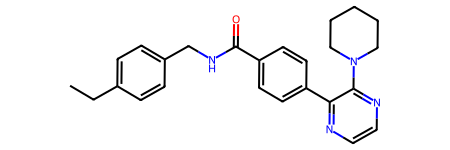

In [5]:
print(f"SMILES:\t{df.smiles[99]}\nlogP:\t{df.logP[99]}\nqed:\t{df.qed[99]}")
molecule = molecule_from_smiles(df.iloc[99].smiles)
print("Molecule:")
molecule

In this cell, we initialize some key variables and mappings essential for processing SMILES representations of chemical compounds.

We start by defining a character set for SMILES notation in the variable SMILE_CHARSET.

Next, we create a dictionary called bond_mapping to map bond types to their corresponding numerical values and vice versa, using Chem.BondType from RDKit.

Then, we convert the SMILE_CHARSET string into a Python list using ast.literal_eval() for further processing.

Moving on, we determine the maximum size of molecules in a dataset (df) by finding the maximum length of SMILES strings present.

Finally, we create dictionaries SMILE_to_index and index_to_SMILE to map characters to indices and vice versa, and combine them into atom_mapping.

We print out the maximum molecule size and the length of the character set for reference.

In [6]:

SMILE_CHARSET = '["C", "B", "F", "I", "H", "O", "N", "S", \
                  "P", "Cl", "Br"]'             
bond_mapping = {
    "SINGLE": 0,
    0: Chem.BondType.SINGLE,
    "DOUBLE": 1,
    1: Chem.BondType.DOUBLE,
    "TRIPLE": 2,
    2: Chem.BondType.TRIPLE,
    "AROMATIC": 3,
    3: Chem.BondType.AROMATIC,
}
SMILE_CHARSET = ast.literal_eval(SMILE_CHARSET)

MAX_MOLSIZE = max(df['smiles'].str.len())
SMILE_to_index = dict((c, i) for i, c in enumerate(SMILE_CHARSET))
index_to_SMILE = dict((i, c) for i, c in enumerate(SMILE_CHARSET))
atom_mapping = dict(SMILE_to_index)
atom_mapping.update(index_to_SMILE)

print("Max molecule size: {}".format(MAX_MOLSIZE))
print("Character set Length: {}".format(len(SMILE_CHARSET)))

Max molecule size: 105
Character set Length: 11


## Hyperparameters

In this cell, we set up some essential parameters for our variational autoencoder (VAE) model used for processing molecular data.

We define BATCH_SIZE as 32, which represents the number of samples processed in each training iteration.

The variable EPOCHS is set to 10, indicating the number of complete passes through the entire dataset during training.

Next, we specify the learning rate for our VAE model as VAE_LR, set to 5e-4.

We define NUM_ATOMS as 120, representing the maximum number of atoms in a molecule.

ATOM_DIM is calculated as the length of our SMILE_CHARSET, indicating the number of different atom types present in our dataset.

Similarly, BOND_DIM is set to 4 plus 1, representing the number of bond types. The additional 1 accounts for a special token representing absence of a bond.

Lastly, we define LATENT_DIM as 435, representing the size of the latent space in our VAE model.

In [7]:
BATCH_SIZE = 32
EPOCHS =10

VAE_LR = 5e-4
NUM_ATOMS = 120 # Maximum number of atoms

ATOM_DIM = len(SMILE_CHARSET)  # Number of atom types
BOND_DIM = 4 + 1  # Number of bond types
LATENT_DIM = 435  # Size of the latent space



Starting with smiles_to_graph, this function utilizes RDKit, a powerful toolkit for cheminformatics, to convert SMILES strings into graph representations.

Firstly, it creates a molecule object using Chem.MolFromSmiles(smiles), which parses the SMILES string and constructs a molecular structure.

Then, it initializes an adjacency matrix and a feature matrix. The adjacency matrix represents bonds between atoms, while the feature matrix represents atom types.

For each atom in the molecule, it assigns a one-hot encoded vector in the feature matrix, indicating the atom type based on the atom_mapping.

Next, it iterates over atom pairs to populate the adjacency matrix with bond information. Bonds between atoms are determined using molecule.GetBondBetweenAtoms(i, j).

Additionally, it handles cases where no bond exists or where no atom is present by adding special tokens to the matrices.

Moving on to graph_to_molecule, this function reconstructs a molecule object from a graph representation.

It first removes atoms with no bonds and bonds that don't connect atoms, ensuring the validity of the molecular structure.

Then, it iterates over atoms in the feature matrix, adding them to the molecule object.

Next, it establishes bonds between atoms based on the adjacency matrix, effectively reconstructing the molecular bonds.

Afterward, it sanitizes the molecule using Chem.SanitizeMol(molecule) to ensure its structural integrity. If sanitization fails, indicating an invalid molecular structure, it returns None.

These functions play a crucial role in bridging the gap between the symbolic representation of molecules (SMILES) and their graph-based representation, facilitating further processing within the model.

In [8]:
def smiles_to_graph(smiles):

    # Converts SMILES to molecule object
    molecule = Chem.MolFromSmiles(smiles)

    # Initialize adjacency and feature tensor
    adjacency = np.zeros((BOND_DIM, NUM_ATOMS, NUM_ATOMS), "float32")
    features = np.zeros((NUM_ATOMS, ATOM_DIM), "float32")

    # loop over each atom in molecule
    for atom in molecule.GetAtoms():
        i = atom.GetIdx()
        atom_type = atom_mapping[atom.GetSymbol()]
        features[i] = np.eye(ATOM_DIM)[atom_type]
        # loop over one-hop neighbors
        for neighbor in atom.GetNeighbors():
            j = neighbor.GetIdx()
            bond = molecule.GetBondBetweenAtoms(i, j)
            bond_type_idx = bond_mapping[bond.GetBondType().name]
            adjacency[bond_type_idx, [i, j], [j, i]] = 1

    # Where no bond, add 1 to last channel (indicating "non-bond")
    # Notice: channels-first
    adjacency[-1, np.sum(adjacency, axis=0) == 0] = 1

    # Where no atom, add 1 to last column (indicating "non-atom")
    features[np.where(np.sum(features, axis=1) == 0)[0], -1] = 1

    return adjacency, features

def graph_to_molecule(graph):

    # Unpack graph
    adjacency, features = graph

    # RWMol is a molecule object intended to be edited
    molecule = Chem.RWMol()

    # Remove "no atoms" & atoms with no bonds
    keep_idx = np.where(
        (np.argmax(features, axis=1) != ATOM_DIM - 1)
        & (np.sum(adjacency[:-1], axis=(0, 1)) != 0)
    )[0]
    features = features[keep_idx]
    adjacency = adjacency[:, keep_idx, :][:, :, keep_idx]

    # Add atoms to molecule
    for atom_type_idx in np.argmax(features, axis=1):
        atom = Chem.Atom(atom_mapping[atom_type_idx])
        _ = molecule.AddAtom(atom)

    # Add bonds between atoms in molecule; based on the upper triangles
    # of the [symmetric] adjacency tensor
    (bonds_ij, atoms_i, atoms_j) = np.where(np.triu(adjacency) == 1)
    for (bond_ij, atom_i, atom_j) in zip(bonds_ij, atoms_i, atoms_j):
        if atom_i == atom_j or bond_ij == BOND_DIM - 1:
            continue
        bond_type = bond_mapping[bond_ij]
        molecule.AddBond(int(atom_i), int(atom_j), bond_type)

    # Sanitize the molecule; for more information on sanitization, see
    # https://www.rdkit.org/docs/RDKit_Book.html#molecular-sanitization
    flag = Chem.SanitizeMol(molecule, catchErrors=True)
    # Let's be strict. If sanitization fails, return None
    if flag != Chem.SanitizeFlags.SANITIZE_NONE:
        return None

    return molecule

In [16]:
print(df.iloc[2].smiles)

a,f = smiles_to_graph(df.iloc[29].smiles)
print("Adjacency matrix:", a.shape)
print("Feature matrix:", f.shape)

N#Cc1ccc(-c2ccc(O[C@@H](C(=O)N3CCCC3)c3ccccc3)cc2)cc1
Adjacency matrix: (5, 120, 120)
Feature matrix: (120, 11)


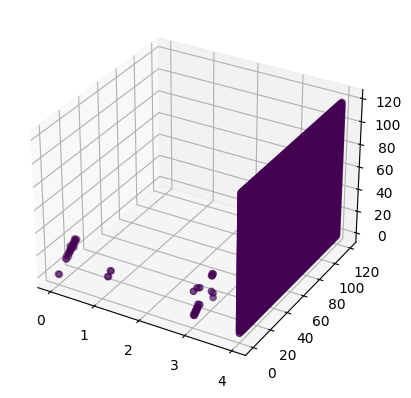

In [15]:

matrix_3d = a.copy()  # replace this with your actual matrix

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x, y, z = matrix_3d.nonzero()
c = matrix_3d[x, y, z]  # color values

ax.scatter(x, y, z, c=c)
plt.show()

## Build Dataloader

Now, let's explore the DataGenerator class, which is a custom data generator inheriting from keras.utils.Sequence. This class is responsible for generating batches of data during training.

In the __init__ method, we initialize various attributes such as the dataset (data), mapping, maximum length of molecules (max_len), batch size (batch_size), and whether to shuffle the data (shuffle). We also call the on_epoch_end method to update indices after each epoch.

The __len__ method returns the number of batches in the dataset.

In the __getitem__ method, we generate one batch of data. We calculate the indices of the current batch and retrieve the corresponding data. Then, we call the data_generation method to generate the molecular features and properties.

The on_epoch_end method updates the indices after each epoch, optionally shuffling the data.

The load method loads molecular adjacency matrices, feature matrices from SMILES representation, and their respective QED (quantitative estimation of druglikeness) values.

Lastly, the data_generation method generates input data for the model. It creates empty arrays to store molecular features, properties, and QED values for the batch. Then, it iterates over the batch, loading data for each molecule using the load method.

In [17]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, data, mapping, max_len, batch_size=6, shuffle=True):
        """
        Initialization
        """
        self.data = data
        self.indices = self.data.index.tolist()
        self.mapping = mapping
        self.max_len = max_len
        self.batch_size = batch_size
        self.shuffle = shuffle
        
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.data) / self.batch_size))

    def __getitem__(self, index):
        if (index + 1) * self.batch_size > len(self.indices):
            self.batch_size = len(self.indices) - index * self.batch_size
        # Generate one batch of data
        # Generate indices of the batch
        index = self.indices[index * self.batch_size : (index + 1) * self.batch_size]
        # Find list of IDs
        batch = [self.indices[k] for k in index]
        mol_features, mol_property = self.data_generation(batch)

        return mol_features, mol_property

    def on_epoch_end(self):

        """
        Updates indexes after each epoch
        """
        self.indices = np.arange(len(self.data))  # Modify to update indices correctly
        if self.shuffle == True:
            np.random.shuffle(self.indices)

    def load(self, idx):
        """
        Load molecules adjacency matrix and features matrix from SMILE representation 
        and their respective SAS value.
        """
        qed = self.data.loc[idx]['qed']

        adjacency, features = smiles_to_graph(self.data.loc[idx]['smiles'])

        return adjacency, features, qed
    
    def data_generation(self, batch):
        x1 = np.empty((self.batch_size, BOND_DIM, self.max_len, self.max_len))
        x2 = np.empty((self.batch_size, self.max_len, len(self.mapping)))
        x3 = np.empty((self.batch_size, ))
        
        for i, batch_id in enumerate(batch):
            x1[i,], x2[i,], x3[i,] = self.load(batch_id)

        return (np.array(x1), np.array(x2)), np.array(x3)



##  Generate training set

In [18]:
train_df = df.sample(frac=0.75,random_state=42) #random state is a seed value
test_df = df.drop(train_df.index)
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In this cell, we define a custom layer called RelationalGraphConvLayer, which implements a relational graph convolution operation.

The constructor (__init__ method) accepts various parameters such as the number of units, activation function, use of bias, initializers, and regularizers. These parameters allow customization of the layer's behavior.

Inside the constructor, we initialize the layer's attributes based on the provided parameters.

The build method is called during the layer's initialization and is responsible for creating the layer's weights. It determines the shape of the kernel weights based on the input shapes.

The call method implements the layer's forward pass. It takes adjacency matrices and feature matrices as inputs and performs the following operations:

Aggregate information from neighboring atoms using matrix multiplication (tf.matmul).
Apply a linear transformation by multiplying with the kernel weights.
Optionally, add bias terms.
Reduce the dimensionality of the output tensor by summing over the bond types dimension.
Apply the activation function.
The resulting tensor represents the output of the relational graph convolution operation.

In [19]:
class RelationalGraphConvLayer(tf.keras.layers.Layer):
    def __init__(
        self,
        units=128,
        activation="relu",
        use_bias=False,
        kernel_initializer="glorot_uniform",
        bias_initializer="zeros",
        kernel_regularizer=None,
        bias_regularizer=None,
        **kwargs
    ):
        super().__init__(**kwargs)

        self.units = units
        self.activation = tf.keras.activations.get(activation)
        self.use_bias = use_bias
        self.kernel_initializer = tf.keras.initializers.get(kernel_initializer)
        self.bias_initializer = tf.keras.initializers.get(bias_initializer)
        self.kernel_regularizer = tf.keras.regularizers.get(kernel_regularizer)
        self.bias_regularizer = tf.keras.regularizers.get(bias_regularizer)

    def build(self, input_shape):
        bond_dim = input_shape[0][1]
        atom_dim = input_shape[1][2]

        self.kernel = self.add_weight(
            shape=(bond_dim, atom_dim, self.units),
            initializer=self.kernel_initializer,
            regularizer=self.kernel_regularizer,
            trainable=True,
            name="W",
            dtype=tf.float32,
        )

        if self.use_bias:
            self.bias = self.add_weight(
                shape=(bond_dim, 1, self.units),
                initializer=self.bias_initializer,
                regularizer=self.bias_regularizer,
                trainable=True,
                name="b",
                dtype=tf.float32,
            )

        self.built = True

    def call(self, inputs, training=False):
        adjacency, features = inputs
        # Aggregate information from neighbors
        x = tf.matmul(adjacency, features[:, None, :, :])
        # Apply linear transformation
        x = tf.matmul(x, self.kernel)
        if self.use_bias:
            x += self.bias
        # Reduce bond types dim
        x_reduced = tf.reduce_sum(x, axis=1)
        # Apply non-linear transformation
        return self.activation(x_reduced)



In this cell, we define the `get_encoder` function to construct the encoder part of a variational autoencoder (VAE) for processing molecular data, along with a custom layer called `Symmetrify`.

1. **Encoder Construction (`get_encoder` function):**
   - This function constructs the encoder part of a VAE, which transforms input molecular graphs into latent space representations.
   - It accepts several parameters:
     - `gconv_units`: List of units for graph convolutional layers.
     - `latent_dim`: Dimensionality of the latent space.
     - `adjacency_shape`: Shape of the adjacency matrix input.
     - `feature_shape`: Shape of the feature matrix input.
     - `dense_units`: List of units for densely connected layers.
     - `dropout_rate`: Dropout rate for regularization.
   - Inside the function, input layers for adjacency and feature matrices are defined using `tf.keras.layers.Input`.
   - The feature matrix is propagated through multiple relational graph convolutional layers, specified by `gconv_units`, using the custom layer `RelationalGraphConvLayer`.
   - The 2D representation of the molecule is then reduced to 1D using `tf.keras.layers.GlobalAveragePooling1D`.
   - Next, the 1D representation passes through densely connected layers, specified by `dense_units`, with ReLU activation and dropout regularization.
   - Finally, the mean (`z_mean`) and log variance (`log_var`) of the latent space are computed using dense layers, and an instance of the encoder model is created using `tf.keras.Model`.

2. **Symmetrify Layer (`Symmetrify` class):**
   - This custom layer implements symmetric matrix operations to ensure symmetry in adjacency matrices.
   - The `call` method takes an input tensor and returns the symmetrized version of the tensor by averaging it with its transpose along the appropriate dimensions.

By combining these components, we create an encoder model that transforms input molecular graphs into meaningful latent space representations while ensuring symmetry in the graph structure.



In [20]:
def get_encoder(gconv_units, latent_dim, adjacency_shape, feature_shape, dense_units,dropout_rate ):
    '''
    Reference: https://keras.io/examples/generative/wgan-graphs/
    '''
    adjacency = tf.keras.layers.Input(shape=adjacency_shape)
    features = tf.keras.layers.Input(shape=feature_shape)

    # Propagate through one or more graph convolutional layers
    features_transformed = features
    for units in gconv_units:
        features_transformed = RelationalGraphConvLayer(units)(
            [adjacency, features_transformed]
        )
    # Reduce 2-D representation of molecule to 1-D
    x = tf.keras.layers.GlobalAveragePooling1D()(features_transformed)

    # Propagate through one or more densely connected layers
    for units in dense_units:
        x = tf.keras.layers.Dense(units, activation="relu")(x)
        x = tf.keras.layers.Dropout(dropout_rate)(x)
    
    z_mean = tf.keras.layers.Dense(latent_dim, dtype="float32", name="z_mean")(x)
    log_var = tf.keras.layers.Dense(latent_dim, dtype="float32", name="log_var")(x)
    
    encoder = tf.keras.Model([adjacency, features], [z_mean, log_var], name="encoder")

    return encoder

class Symmetrify(tf.keras.layers.Layer):
    def call(self, inputs):
        return (inputs + tf.transpose(inputs, (0, 1, 3, 2))) / 2

def get_decoder(dense_units, dropout_rate, latent_dim, adjacency_shape, feature_shape):
    '''
    Reference: https://keras.io/examples/generative/wgan-graphs/
    '''
    latent_inputs = tf.keras.Input(shape=(latent_dim,))

    x = latent_inputs
    for units in dense_units:
        x = tf.keras.layers.Dense(units, activation="tanh")(x)
        x = tf.keras.layers.Dropout(dropout_rate)(x)

    # Map outputs of previous layer (x) to [continuous] adjacency tensors (x_adjacency)
    x_adjacency = tf.keras.layers.Dense(np.prod(adjacency_shape))(x)
    x_adjacency = tf.keras.layers.Reshape(adjacency_shape)(x_adjacency)
    # Symmetrify tensors in the last two dimensions
    x_adjacency = Symmetrify()(x_adjacency)
    x_adjacency = tf.keras.layers.Softmax(axis=1)(x_adjacency)

    # Map outputs of previous layer (x) to [continuous] feature tensors (x_features)
    x_features = tf.keras.layers.Dense(np.prod(feature_shape))(x)
    x_features = tf.keras.layers.Reshape(feature_shape)(x_features)
    x_features = tf.keras.layers.Softmax(axis=2)(x_features)

    decoder = tf.keras.Model(latent_inputs, outputs=[x_adjacency, x_features], name="decoder")

    return decoder



In this cell, we define the `get_decoder` function to construct the decoder part of a variational autoencoder (VAE) for processing molecular data.

1. **Decoder Construction (`get_decoder` function):**
   - This function constructs the decoder part of a VAE, which generates molecular graphs from latent space representations.
   - It accepts several parameters:
     - `dense_units`: List of units for densely connected layers.
     - `dropout_rate`: Dropout rate for regularization.
     - `latent_dim`: Dimensionality of the latent space.
     - `adjacency_shape`: Shape of the adjacency matrix input.
     - `feature_shape`: Shape of the feature matrix input.
   - Inside the function, an input layer for the latent space representations is defined using `tf.keras.Input`.
   - The latent inputs pass through densely connected layers with hyperbolic tangent (`tanh`) activation and dropout regularization, specified by `dense_units` and `dropout_rate`.
   - The outputs of the dense layers are mapped to continuous adjacency tensors (`x_adjacency`) and continuous feature tensors (`x_features`) using dense layers and reshaping operations.
   - To ensure symmetry in the adjacency matrices, the `Symmetrify` layer is applied to `x_adjacency`.
   - Softmax activation is applied along appropriate dimensions to ensure valid probability distributions for adjacency and feature tensors.
   - Finally, an instance of the decoder model is created using `tf.keras.Model`.

By using the `get_decoder` function, we create a decoder model that generates molecular graphs from latent space representations, completing the VAE architecture for molecular data processing.


## Build Sampling layer

[Slide Title: Code Explanation]

[Slide Content: Sampling Layer Class]

[Voice Over: Begins]

In this cell, we define a custom layer called `Sampling`, which is used in variational autoencoders (VAEs) to sample latent space vectors.

1. **Sampling Layer (`Sampling` class):**
   - This custom layer implements the sampling process to generate latent space vectors from the mean (`z_mean`) and log variance (`z_log_var`) of the latent space distribution.
   - The `call` method of the layer takes the mean and log variance as inputs.
   - It first determines the shape of the input tensors to extract the batch size (`batch`) and dimensionality (`dim`) of the latent space.
   - Next, it generates random noise (`epsilon`) from a standard normal distribution with the same shape as the input tensors.
   - The sampled latent space vectors (`z`) are computed using the reparameterization trick, which involves adding the mean and multiplying by the standard deviation (square root of the exponential of half the log variance) of the latent space distribution.
   - The sampled latent space vectors are returned as the output of the layer.

By implementing the `Sampling` layer, we enable the VAE model to generate diverse latent space representations for input data, facilitating the generation of new molecular structures during training and inference.

[Voice Over: Ends]

---

This explanation provides an overview of the `Sampling` layer class and its role in the VAE architecture for generating latent space representations. Let me know if you need further clarification or have any questions!

In [21]:
class Sampling(tf.keras.layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_log_var)[0]
        dim = tf.shape(z_log_var)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

## Build the VAE


In this class `MoleculeGenerator`, we integrate the variational autoencoder (VAE) architecture for molecular graph generation. Let's break down the functionalities of each component and its significance in the context of the VAE model.

1. **Initialization (`__init__` method):**
   - This method initializes the `MoleculeGenerator` instance by storing references to the encoder and decoder models, along with additional properties such as the maximum length of the molecule.
   - It also initializes metric trackers (`train_total_loss_tracker` and `val_total_loss_tracker`) to monitor the training and validation losses over epochs.

2. **Training Step (`train_step` method):**
   - This method defines the training logic for the model.
   - It receives input data containing molecular features and properties.
   - Within a gradient tape context, it computes the reconstruction loss, KL divergence loss, property prediction loss, and graph loss.
   - These losses are combined to calculate the total loss, which is optimized using gradient descent.
   - The `train_total_loss_tracker` is updated with the calculated total loss.

3. **Testing Step (`test_step` method):**
   - Similar to the training step, this method defines the testing logic for the model.
   - It calculates the loss metrics without gradient computation and optimization.
   - The `val_total_loss_tracker` is updated with the calculated validation loss.

4. **Loss Calculation (`calculate_loss` method):**
   - This method computes the total loss based on various components, including KL divergence loss, property prediction loss, graph reconstruction losses (adjacency and features), and gradient penalty for enforcing the Lipschitz constraint.
   - It ensures that the model learns to generate molecular graphs with desired properties while preserving the structure of the input data.

5. **Gradient Penalty (`_gradient_penalty` method):**
   - This method calculates the gradient penalty for enforcing the Lipschitz constraint, which encourages smoothness in the latent space.
   - It computes the gradient norms of interpolated graphs and penalizes deviations from the Lipschitz constraint.
   - By adding this penalty term to the loss function during training, the model learns more stable and continuous latent space representations.

6. **Inference (`inference` method):**
   - This method generates new molecular graphs by sampling latent space vectors and decoding them using the decoder model.
   - It utilizes random noise vectors sampled from a standard normal distribution to generate diverse molecular structures.
   - The generated molecular graphs are obtained by converting the one-hot encoded adjacency and feature tensors into molecule objects.

7. **Call (`call` method):**
   - This method defines the forward pass of the model.
   - It computes the latent space representations (`z_mean`, `log_var`) using the encoder model.
   - Latent space vectors are sampled using the `Sampling` layer, and then decoded into reconstructed adjacency and feature tensors using the decoder model.
   - Additionally, the property prediction layer predicts molecular properties based on the latent space representations.
   - The method returns various outputs including latent space representations, property predictions, and reconstructed graph tensors.

Each method serves a specific purpose in the VAE model architecture, contributing to the overall process of generating molecular graphs while learning meaningful latent representations. These functionalities are essential for training and evaluating the model's performance in generating molecules with desired properties.

In [22]:
class MoleculeGenerator(tf.keras.Model):
    def __init__(self, encoder, decoder, max_len, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.property_prediction_layer = tf.keras.layers.Dense(1)
        self.max_len = max_len

        self.train_total_loss_tracker = tf.keras.metrics.Mean(name="train_total_loss")
        self.val_total_loss_tracker = tf.keras.metrics.Mean(name="val_total_loss")
        # self.train_total_loss_tracker = []
        # self.val_total_loss_tracker = []
    
    def train_step(self, data):
        
        mol_features, mol_property = data
        # print(mol_features, mol_property, data)
        graph_real = mol_features
        self.batch_size = tf.shape(mol_property)[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, property_prediction, \
             reconstruction_adjacency, reconstruction_features = self(mol_features,
                                                                             training=True)
            graph_generated = [reconstruction_adjacency, reconstruction_features]
            total_loss = self.calculate_loss(z_log_var,
                                             z_mean,
                                             mol_property,
                                             property_prediction,
                                             graph_real,
                                             graph_generated,
                                             is_train=True)

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.train_total_loss_tracker.update_state(total_loss)
        # self.train_total_loss_tracker.append(total_loss)
        return {
            "train_loss": self.train_total_loss_tracker.result()
        }

    def test_step(self, data):
        mol_features, mol_property = data
        z_mean, z_log_var, property_prediction, \
        reconstruction_adjacency, reconstruction_features = self(mol_features,
                                                                training=False)
        total_loss = self.calculate_loss(z_log_var,
                                        z_mean,
                                        mol_property, 
                                        property_prediction,
                                        graph_real=mol_features,
                                        graph_generated=[reconstruction_adjacency, 
                                                        reconstruction_features],
                                        is_train=False)

        self.val_total_loss_tracker.update_state(total_loss)
        # self.val_total_loss_tracker.append(total_loss)
        return {
            "val_loss": self.val_total_loss_tracker.result()
        }

    def calculate_loss(self,
                       z_log_var,
                       z_mean,
                       mol_property,
                       property_prediction,
                       graph_real,
                       graph_generated,
                       is_train):
        adjacency_real, features_real = graph_real
        adjacency_generated, features_generated = graph_generated
        
        adjacency_reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    tf.keras.losses.categorical_crossentropy(
                                                        adjacency_real,
                                                        adjacency_generated
                                                        ),
                                                        axis=(1,2)
                    )
            )
        features_reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    tf.keras.losses.categorical_crossentropy(
                                                        features_real,
                                                        features_generated
                                                        ),
                                                        axis=(1)
                    )
            )
        kl_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), 1)
        kl_loss = tf.reduce_mean(kl_loss)
         
    
        property_prediction_loss = tf.reduce_mean(
    tf.keras.losses.binary_crossentropy(tf.expand_dims(mol_property, axis = 1), property_prediction)
)
        
        if is_train:
            graph_loss = self._gradient_penalty(graph_real, graph_generated)
        else:
            graph_loss = 0

        return kl_loss + property_prediction_loss + graph_loss + adjacency_reconstruction_loss + features_reconstruction_loss

    def _gradient_penalty(self, graph_real, graph_generated):
        # Unpack graphs
        adjacency_real, features_real = graph_real
        adjacency_generated, features_generated = graph_generated

        # Generate interpolated graphs (adjacency_interp and features_interp)
        alpha = tf.random.uniform([self.batch_size])
        alpha = tf.reshape(alpha, (self.batch_size, 1, 1, 1))
        alpha = tf.cast(alpha, tf.float32)
        adjacency_real = tf.cast(adjacency_real, tf.float32)
        adjacency_interp = (adjacency_real * alpha) + (1 - alpha) * adjacency_generated
        alpha = tf.reshape(alpha, (self.batch_size, 1, 1))
        alpha = tf.cast(alpha, tf.float32)
        features_real = tf.cast(features_real, tf.float32)
        features_interp = (features_real * alpha) + (1 - alpha) * features_generated

        # Compute the logits of interpolated graphs
        with tf.GradientTape() as tape:
            tape.watch(adjacency_interp)
            tape.watch(features_interp)
            _, _, logits, _,_ = self(
                [adjacency_interp, features_interp], training=True
            )

        # Compute the gradients with respect to the interpolated graphs
        grads = tape.gradient(logits, [adjacency_interp, features_interp])
        # Compute the gradient penalty
        grads_adjacency_penalty = (1 - tf.norm(grads[0], axis=1)) ** 2
        grads_features_penalty = (1 - tf.norm(grads[1], axis=2)) ** 2
        return tf.reduce_mean(
            tf.reduce_mean(grads_adjacency_penalty, axis=(-2, -1))
            + tf.reduce_mean(grads_features_penalty, axis=(-1))
        )
    
    def inference(self, batch_size):
        z = tf.random.normal((batch_size, LATENT_DIM))
        reconstruction_adjacency, reconstruction_features = self.decoder.predict(z)
        # obtain one-hot encoded adjacency tensor
        adjacency = tf.argmax(reconstruction_adjacency, axis=1)
        adjacency = tf.one_hot(adjacency, depth=BOND_DIM, axis=1)
        # Remove potential self-loops from adjacency
        adjacency = tf.linalg.set_diag(adjacency, tf.zeros(tf.shape(adjacency)[:-1]))
        # obtain one-hot encoded feature tensor
        features = tf.argmax(reconstruction_features, axis=2)
        features = tf.one_hot(features, depth=ATOM_DIM, axis=2)
        return [
            graph_to_molecule([adjacency[i].numpy(), features[i].numpy()])
            for i in range(batch_size)
        ]
    
    def call(self, inputs):
        z_mean, log_var = self.encoder(inputs)
        z = Sampling()([z_mean, log_var])

        reconstruction_adjacency, reconstruction_features = self.decoder(z)

        property_prediction = self.property_prediction_layer(z_mean)

        return z_mean, log_var, property_prediction, reconstruction_adjacency, reconstruction_features

Certainly! Let's delve deeper into the loss calculation process, the concept of gradient penalty, and its significance in training generative models like the variational autoencoder (VAE) for molecular graph generation:

1. **Loss Calculation:**
   - In the VAE framework, the loss function consists of multiple components that collectively guide the learning process:
     - **KL Divergence Loss:** Measures the discrepancy between the distribution of latent space representations learned by the encoder and a predefined prior distribution (usually a standard normal distribution). Minimizing KL divergence encourages the learned latent space to follow a prior distribution, promoting better generalization and regularization.
     - **Property Prediction Loss:** Measures the error in predicting molecular properties based on the latent space representations. This loss guides the model to learn representations that capture relevant information about the input data's properties, facilitating property-aware molecular graph generation.
     - **Graph Reconstruction Losses (Adjacency and Features):** Quantify the difference between the input molecular graphs and their reconstructions generated by the decoder. These losses ensure that the generated molecular graphs faithfully preserve the structural and topological characteristics of the input data.
   
   The combination of these losses allows the VAE to simultaneously learn meaningful latent representations, predict molecular properties, and reconstruct input graphs, leading to the generation of high-quality molecular structures.

2. **Gradient Penalty:**
   - Gradient penalty is a regularization technique used to enforce smoothness and continuity in the latent space of generative models.
   - In the context of the VAE for molecular graph generation, the gradient penalty aims to ensure that the model's latent space representations exhibit desirable properties, such as Lipschitz continuity.
   - The gradient penalty is calculated based on the gradients of interpolated graphs (generated by linearly interpolating between real and generated graphs) with respect to their inputs (adjacency and feature tensors).
   - By penalizing deviations from the Lipschitz constraint, the gradient penalty encourages the model to learn smooth and stable latent space representations, which in turn leads to better generalization and improved sample quality during generation.
   
   Essentially, the gradient penalty acts as a regularization term that promotes the formation of a smooth manifold in the latent space, preventing the model from learning overly complex or discontinuous representations.

Overall, the combination of loss calculation and gradient penalty provides a comprehensive training framework for VAEs in molecular graph generation, guiding the model to learn meaningful latent representations while ensuring smoothness and continuity in the learned latent space.

## Train the model

In [23]:
train_loader = DataGenerator(
    data=train_df[:10000],
    mapping = SMILE_to_index, 
    max_len = NUM_ATOMS,
    batch_size=BATCH_SIZE
)

validation_loader = DataGenerator(
    data=test_df[:10000],
    mapping = SMILE_to_index, 
    max_len = NUM_ATOMS,
    batch_size=BATCH_SIZE
    )

This code snippet demonstrates the setup and training of a variational autoencoder (VAE) model for molecular graph generation. Let's break down each component and its role in the training process:

1. **Optimizer Initialization:**
   - An Adam optimizer is initialized with a specified learning rate (`VAE_LR`). Adam optimizer is commonly used for training neural networks due to its adaptive learning rate capabilities and efficiency in optimizing non-convex objectives.

2. **Encoder and Decoder Initialization:**
   - The `get_encoder` and `get_decoder` functions are used to initialize the encoder and decoder models, respectively.
   - The encoder and decoder architectures are configured with specific parameters such as the number of graph convolutional layers (`gconv_units`), dense units, dropout rates, and input shapes.
   - These models are essential components of the VAE architecture, responsible for encoding input molecular graphs into latent space representations and decoding them back into reconstructed graphs.

3. **Model Initialization:**
   - An instance of the `MoleculeGenerator` class is created by passing the initialized encoder and decoder models, along with the maximum molecule size (`MAX_MOLSIZE`).
   - The `MoleculeGenerator` class encapsulates the entire VAE architecture and provides methods for training and inference.

4. **Model Compilation:**
   - The model is compiled using the Adam optimizer initialized earlier.
   - Since the loss function and training step logic are defined within the `MoleculeGenerator` class, no explicit loss function is specified here.

5. **Training:**
   - The `fit` method is called on the model instance to train the VAE.
   - Training is performed for a specified number of epochs (`epochs=10`) using data from the `train_loader`.
   - Validation data from the `validation_loader` is provided for monitoring the model's performance during training.
   - The training history, including loss and metrics values, is stored in the `history` variable for later analysis and visualization.

Overall, this code sets up and trains a VAE model for molecular graph generation, leveraging the defined encoder and decoder architectures and the custom `MoleculeGenerator` class to facilitate the training process.

In [24]:
vae_optimizer = tf.keras.optimizers.Adam(
    learning_rate=VAE_LR
)

encoder = get_encoder(
    gconv_units=[9],
    adjacency_shape=(BOND_DIM, NUM_ATOMS, NUM_ATOMS),
    feature_shape=(NUM_ATOMS, ATOM_DIM),
    latent_dim=LATENT_DIM,
    dense_units=[512],
    dropout_rate=0.0,
)
decoder = get_decoder(
    dense_units=[128, 256, 512],
    dropout_rate=0.2,
    latent_dim=LATENT_DIM,
    adjacency_shape=(BOND_DIM, NUM_ATOMS, NUM_ATOMS),
    feature_shape=(NUM_ATOMS, ATOM_DIM)
)

model = MoleculeGenerator(encoder, 
                          decoder,
                          MAX_MOLSIZE)

model.compile(vae_optimizer)

history = model.fit(train_loader,
                    epochs=10,
                    validation_data=validation_loader)


Epoch 1/10


c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


18/24 ━━━━━━━━━━━━━━━━━━━━ 3s 645ms/step - train_loss: 69603.1328

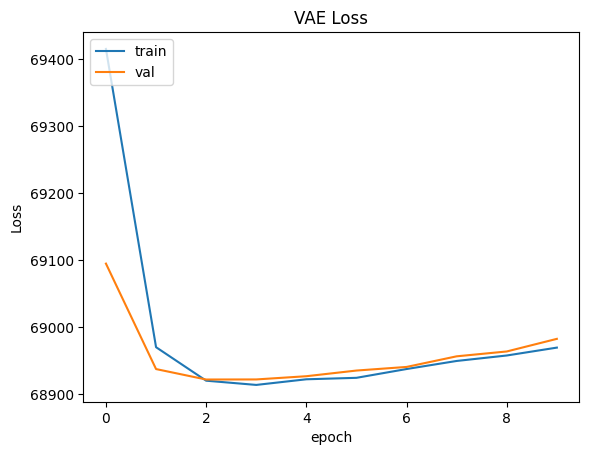

In [109]:
plt.plot(history.history['train_total_loss'])
plt.plot(history.history['val_val_total_loss'])
plt.title('VAE Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Model Inferencing

We would be inferring our model to predict over random latent space and try to generate 100 new valid molecules.

### Generate unique Molecules with the model

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step


e:\IITB\SEM8\ME793\Drug Discovery\Drug-Discovery\.venv\Lib\site-packages\rdkit\Chem\Draw\IPythonConsole.py:258: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


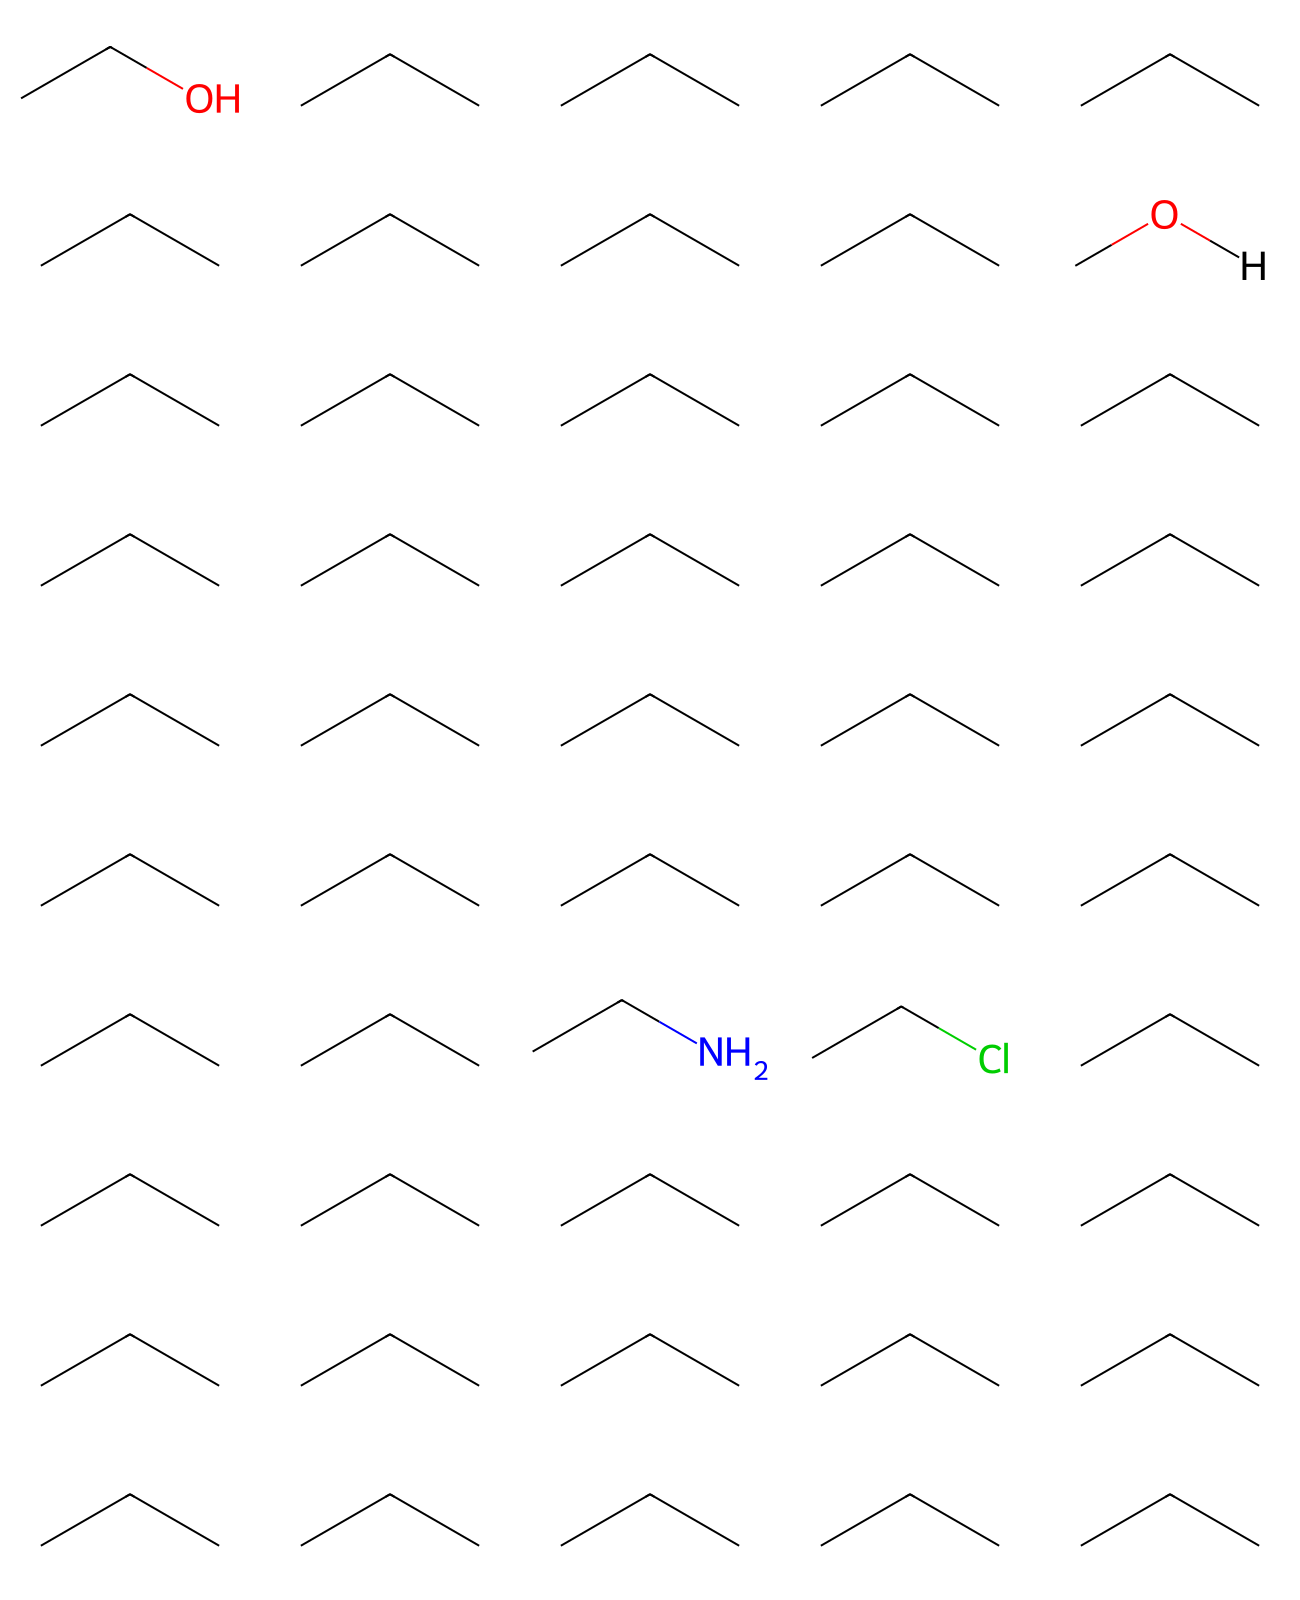

In [110]:
molecules = model.inference(1000)

MolsToGridImage(
    [m for m in molecules if m is not None][:1000], molsPerRow=5, subImgSize=(260, 160)
)